# Define neural networks for classification
We need a neural network with 128 inputs and 10 outputs (one for each audio class). 

For multilabel classifications it is not recommended to use softmax as output layer but sigmoid (https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/)

We've decided finally to go for **multiclass classification**, so we'll use softmax

### Load training and evaluation sets

In [199]:
from pathlib import Path
import pickle

base_dir = "./features/"

load_file = f"{base_dir}X_train.pkl"
with open(load_file, "rb") as load_file:
    X_train = pickle.load(load_file)
    
load_file = f"{base_dir}y_train.pkl"
with open(load_file, "rb") as load_file:
    y_train = pickle.load(load_file)
    
load_file = f"{base_dir}X_val.pkl"
with open(load_file, "rb") as load_file:
    X_val = pickle.load(load_file)
    
load_file = f"{base_dir}y_val.pkl"
with open(load_file, "rb") as load_file:
    y_val = pickle.load(load_file)

### Load labels

In [200]:
load_file = f"{base_dir}multiLabelBinarizer.pkl"
with open(load_file, "rb") as load_file:
    mlb = pickle.load(load_file)

### Add one dimension to our data for NN

In [172]:
#X_train = X_train.reshape(1, X_train.shape[0], 128)
#X_val = X_val.reshape(1, X_val.shape[0], 128)

In [194]:
print(type(X_train), X_train.shape)
print(type(X_train[0]), X_train[0].shape)
print(type(X_train[0][0]), X_train[0][0].shape)
print(type(X_train[0][0][0]), X_train[0][0][0])

<class 'numpy.ndarray'> (18, 10, 128)
<class 'numpy.ndarray'> (10, 128)
<class 'numpy.ndarray'> (128,)
<class 'numpy.int32'> 110


In [197]:
print(type(y_train), y_train.shape)
print(type(y_train[0]), y_train[0].shape)
print(type(y_train[0][0]), y_train[0][0].shape)

<class 'numpy.ndarray'> (18, 10)
<class 'numpy.ndarray'> (10,)
<class 'numpy.int32'> ()


## Neural Network from Keras examples

In [201]:
import keras
from keras import callbacks

keras.backend.clear_session()


def build_and_compile_model():
    inputs = keras.layers.Input(X_train[0].shape, name="embedding")

    x = keras.layers.Dense(256, activation="relu", name="dense_1")(inputs)
    x = keras.layers.Dropout(0.15, name="dropout_1")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_2")(x)
    x = keras.layers.Dropout(0.2, name="dropout_2")(x)

    x = keras.layers.Dense(192, activation="relu", name="dense_3")(x)
    x = keras.layers.Dropout(0.25, name="dropout_3")(x)

    x = keras.layers.Dense(384, activation="relu", name="dense_4")(x)
    x = keras.layers.Dropout(0.2, name="dropout_4")(x)
    x = keras.layers.Flatten()(x)

    # outputs = keras.layers.Dense(len(selected_classes_indexes), activation="sigmoid", name="ouput")(x)
    # Change to multiclass
    outputs = keras.layers.Dense(len(mlb.classes_), activation="softmax", name="ouput")(x)
    

    model = keras.Model(inputs=inputs, outputs=outputs, name="sound_recognition")

    model.compile(
        optimizer=Adam(learning_rate=1.9644e-5),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy", keras.metrics.AUC(name="auc")],
    )

    return model


model2 = build_and_compile_model()
model2.trainable = True
model2.summary()

Model: "sound_recognition"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (InputLayer)      [(None, 10, 128)]         0         
                                                                 
 dense_1 (Dense)             (None, 10, 256)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 10, 256)           0         
                                                                 
 dense_2 (Dense)             (None, 10, 384)           98688     
                                                                 
 dropout_2 (Dropout)         (None, 10, 384)           0         
                                                                 
 dense_3 (Dense)             (None, 10, 192)           73920     
                                                                 
 dropout_3 (Dropout)         (None, 10, 192)     

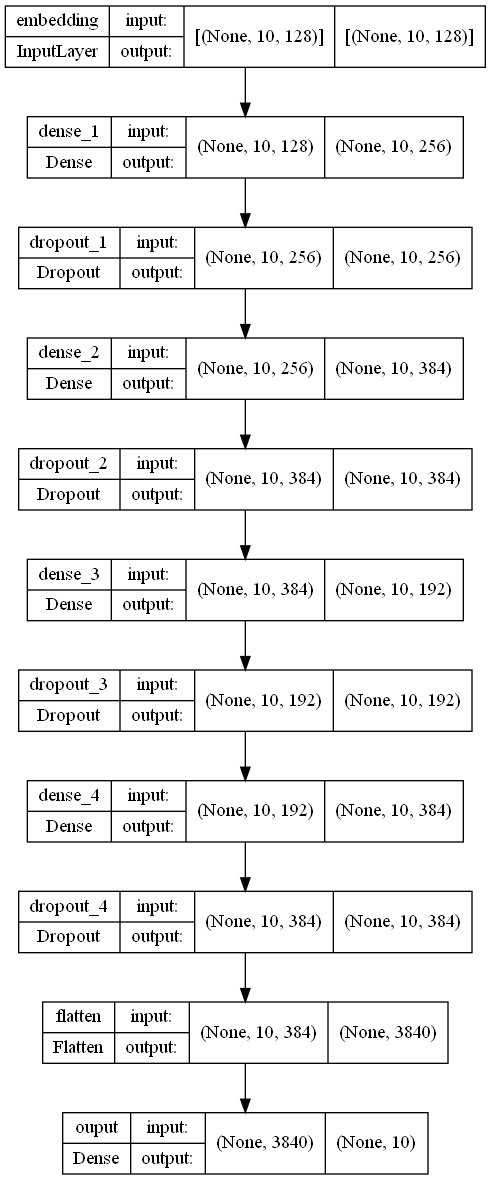

In [202]:
plot_model(model2, show_shapes=True)

In [211]:
import numpy as np
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


history2 = model2.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
1065/1065 [==============================] - 52s 49ms/step - loss: 2.3617 - accuracy: 0.6300 - auc: 0.8818 - val_loss: 1.4969 - val_accuracy: 0.6676 - val_auc: 0.9211
Epoch 2/100
1065/1065 [==============================] - 49s 46ms/step - loss: 1.9129 - accuracy: 0.6610 - auc: 0.8976 - val_loss: 1.4336 - val_accuracy: 0.6638 - val_auc: 0.9258
Epoch 3/100
1065/1065 [==============================] - 49s 46ms/step - loss: 1.8667 - accuracy: 0.6629 - auc: 0.9038 - val_loss: 1.3034 - val_accuracy: 0.6827 - val_auc: 0.9319
Epoch 4/100
1065/1065 [==============================] - 50s 47ms/step - loss: 1.6360 - accuracy: 0.6967 - auc: 0.9205 - val_loss: 1.2770 - val_accuracy: 0.6817 - val_auc: 0.9336
Epoch 5/100
1065/1065 [==============================] - 49s 46ms/step - loss: 1.6042 - accuracy: 0.6845 - auc: 0.9133 - val_loss: 1.3329 - val_accuracy: 0.6591 - val_auc: 0.9334
Epoch 6/100
1065/1065 [==============================] - 49s 46ms/step - loss: 1.5829 - accuracy: 0.7023 

In [212]:
model2.save(f"{base_dir}keras_audio.h5")

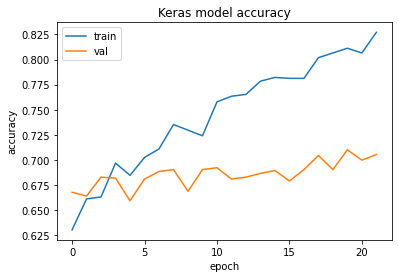

In [213]:
import matplotlib.pyplot as plt

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

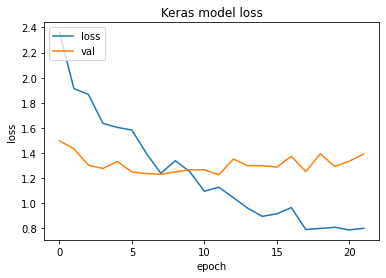

In [214]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

### Same model with different batch size

In [215]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)
history4 = model2.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
17/17 [==============================] - 0s 26ms/step - loss: 1.0505 - accuracy: 0.7718 - auc: 0.9513 - val_loss: 1.2256 - val_accuracy: 0.6827 - val_auc: 0.9405
Epoch 2/100
17/17 [==============================] - 0s 20ms/step - loss: 1.0381 - accuracy: 0.7690 - auc: 0.9502 - val_loss: 1.2246 - val_accuracy: 0.6855 - val_auc: 0.9399
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 0.9486 - accuracy: 0.7643 - auc: 0.9556 - val_loss: 1.2254 - val_accuracy: 0.6864 - val_auc: 0.9401
Epoch 4/100
17/17 [==============================] - 0s 22ms/step - loss: 0.9349 - accuracy: 0.7709 - auc: 0.9562 - val_loss: 1.2262 - val_accuracy: 0.6855 - val_auc: 0.9396
Epoch 5/100
17/17 [==============================] - 0s 24ms/step - loss: 0.9728 - accuracy: 0.7793 - auc: 0.9557 - val_loss: 1.2290 - val_accuracy: 0.6855 - val_auc: 0.9394
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 0.9514 - accuracy: 0.7737 - auc: 0.9576 - val_loss: 1.23

In [216]:
model2.save(f"{base_dir}keras_audio_batch64.h5")

### Another model from Keras
https://keras.io/examples/audio/speaker_recognition_using_cnn/

In [217]:
keras.backend.clear_session()

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=X_train[0].shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(len(mlb.classes_), activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, name="speaker_recognition")


model3 = build_model(X_train[0].shape, len(mlb.classes_))

model3.summary()

# Compile the model using Adam's default learning rate
model3.compile(
    optimizer="Adam", loss=keras.losses.CategoricalCrossentropy(), metrics=["accuracy"]
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "speaker_model.h5"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

ValueError: Exception encountered when calling layer "max_pooling1d_3" (type MaxPooling1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling1d_3/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](max_pooling1d_3/ExpandDims)' with input shapes: [?,1,1,128].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 128), dtype=float32)

### DO NOT USE, it doesn't improve results

In [54]:
#history3 = model3.fit(
#    X_train,
#    y_train,
#    batch_size=32,
#    epochs=20,
#    validation_data=(X_val, y_val),
#)

Epoch 1/20
335/335 [==============================] - 29s 68ms/step - loss: 1.9084 - accuracy: 0.4128 - val_loss: 1.4942 - val_accuracy: 0.4757
Epoch 2/20
335/335 [==============================] - 34s 103ms/step - loss: 1.2980 - accuracy: 0.5573 - val_loss: 1.2917 - val_accuracy: 0.5423
Epoch 3/20
335/335 [==============================] - 37s 110ms/step - loss: 1.1851 - accuracy: 0.5972 - val_loss: 1.3931 - val_accuracy: 0.5316
Epoch 4/20
335/335 [==============================] - 36s 107ms/step - loss: 1.4894 - accuracy: 0.5351 - val_loss: 1.4613 - val_accuracy: 0.5065
Epoch 5/20
335/335 [==============================] - 36s 108ms/step - loss: 2.0796 - accuracy: 0.4660 - val_loss: 1.8940 - val_accuracy: 0.3086
Epoch 6/20
335/335 [==============================] - 35s 104ms/step - loss: 2.0402 - accuracy: 0.4373 - val_loss: 2.4017 - val_accuracy: 0.2610
Epoch 7/20
335/335 [==============================] - 19s 58ms/step - loss: 2.2367 - accuracy: 0.3945 - val_loss: 3.9541 - val_accu

In [218]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, Lambda
import keras.backend as K
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)

def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

time_steps = 10
freq_bins = 128
classes_num = 10

# Hyper parameters
hidden_units = 1024
drop_rate = 0.5
batch_size = 500

# Embedded layers
input_layer = Input(shape=X_train[0].shape)

a1 = Dense(hidden_units)(input_layer)
a1 = BatchNormalization()(a1)
a1 = Activation('relu')(a1)
a1 = Dropout(drop_rate)(a1)

a2 = Dense(hidden_units)(a1)
a2 = BatchNormalization()(a2)
a2 = Activation('relu')(a2)
a2 = Dropout(drop_rate)(a2)

a3 = Dense(hidden_units)(a2)
a3 = BatchNormalization()(a3)
a3 = Activation('relu')(a3)
a3 = Dropout(drop_rate)(a3)
cla = Dense(hidden_units, activation='linear')(a3)
att = Dense(hidden_units, activation='sigmoid')(a3)
b1 = Lambda(attention_pooling, output_shape=pooling_shape)([cla, att])
#b1 = Dense(hidden_units, activation='linear')(a3)
b1 = BatchNormalization()(b1)
b1 = Activation(activation='relu')(b1)
b1 = Dropout(drop_rate)(b1)

output_layer = Dense(classes_num, activation='sigmoid')(b1)

model5 = Model(inputs=input_layer, outputs=output_layer, name="qiuqiangkong")
# model5.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy", auroc])
model5.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model5.summary()

Model: "qiuqiangkong"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 dense (Dense)                  (None, 10, 1024)     132096      ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 10, 1024)    4096        ['dense[0][0]']                  
 alization)                                                                                       
                                                                                                  
 activation_10 (Activation)     (None, 10, 1024)     0           ['batch_normalization[

In [227]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


history5 = model5.fit(
    X_train,
    y_train,
    batch_size=64, # batch size 1 doesn't work
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks =[earlystopping]
)

Epoch 1/100
17/17 [==============================] - 14s 887ms/step - loss: 0.0029 - accuracy: 0.9953 - val_loss: 0.2879 - val_accuracy: 0.7373
Epoch 2/100
17/17 [==============================] - 20s 1s/step - loss: 0.0047 - accuracy: 0.9925 - val_loss: 0.2819 - val_accuracy: 0.7354
Epoch 3/100
17/17 [==============================] - 17s 1s/step - loss: 0.0024 - accuracy: 0.9953 - val_loss: 0.2742 - val_accuracy: 0.7429
Epoch 4/100
17/17 [==============================] - 18s 1s/step - loss: 0.0021 - accuracy: 0.9925 - val_loss: 0.2720 - val_accuracy: 0.7429
Epoch 5/100
17/17 [==============================] - 22s 1s/step - loss: 0.0017 - accuracy: 0.9991 - val_loss: 0.2730 - val_accuracy: 0.7458
Epoch 6/100
17/17 [==============================] - 16s 1s/step - loss: 0.0017 - accuracy: 0.9944 - val_loss: 0.2649 - val_accuracy: 0.7476
Epoch 7/100
17/17 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9962

KeyboardInterrupt: 

In [222]:
model5.save(f"{base_dir}qiuqiangkong.h5")

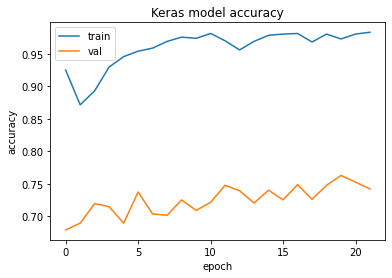

In [223]:
import matplotlib.pyplot as plt

plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Keras model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

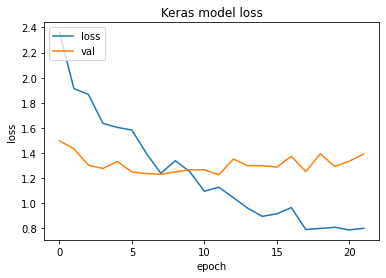

In [224]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Keras model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()